In [3]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:.2f}'.format)

In [15]:
file_path = '../data/train.csv'  
new_df = pd.read_csv(file_path)
new_df.columns

Index(['Unnamed: 0', 'id', 'stmt_date', 'HQ_city', 'legal_struct',
       'ateco_sector', 'def_date', 'fs_year', 'asst_intang_fixed',
       'asst_tang_fixed', 'asst_fixed_fin', 'asst_current', 'AR',
       'cash_and_equiv', 'asst_tot', 'eqty_tot', 'eqty_corp_family_tot',
       'liab_lt', 'liab_lt_emp', 'debt_bank_st', 'debt_bank_lt', 'debt_fin_st',
       'debt_fin_lt', 'AP_st', 'AP_lt', 'debt_st', 'debt_lt', 'rev_operating',
       'COGS', 'prof_operations', 'goodwill', 'inc_financing', 'exp_financing',
       'prof_financing', 'inc_extraord', 'taxes', 'profit', 'days_rec',
       'ebitda', 'roa', 'roe', 'wc_net', 'margin_fin', 'cf_operations'],
      dtype='object')

In [16]:
new_df.isna().sum()

Unnamed: 0                    0
id                            0
stmt_date                     0
HQ_city                     277
legal_struct                  0
ateco_sector                  0
def_date                      0
fs_year                       0
asst_intang_fixed           162
asst_tang_fixed             103
asst_fixed_fin              237
asst_current                  1
AR                           12
cash_and_equiv               17
asst_tot                      0
eqty_tot                      1
eqty_corp_family_tot    1023552
liab_lt                     294
liab_lt_emp                 162
debt_bank_st             121331
debt_bank_lt              90971
debt_fin_st              122772
debt_fin_lt               92068
AP_st                    120635
AP_lt                     92244
debt_st                       5
debt_lt                     155
rev_operating               174
COGS                         24
prof_operations              21
goodwill                     21
inc_fina

# Helper FUNCTIONS
-----
- calculate_default_within_year
- make_quantiles

In [17]:
with open('quantile_custom_bins.pkl', 'rb') as file:
    custom_bins = pickle.load(file)

In [18]:
def calculate_default_within_year(df, stmt_date_col='stmt_date', def_date_col='def_date', days_until_statement=150):
    """
    Calculate a default status within an adjusted timeframe and create a column indicating this in the DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame containing statement and default dates.
    - stmt_date_col (str): Column name for the statement date.
    - def_date_col (str): Column name for the default date.
    - days_until_statement (int): Number of days to add to the statement date before calculating the one-year window. Default is 150.
    
    Returns:
    - float: The mean of the 'default_within_timeframe' column, representing the proportion of defaults within the adjusted one-year period.
    """
    # Convert columns to datetime
    df[stmt_date_col] = pd.to_datetime(df[stmt_date_col])
    df[def_date_col] = pd.to_datetime(df[def_date_col])
    
    # Adjust the statement date by adding days_until_statement
    adjusted_stmt_date = df[stmt_date_col] + pd.DateOffset(days=days_until_statement)
    
    # Calculate one year after the adjusted statement date
    one_year_after = adjusted_stmt_date + pd.DateOffset(years=1)
    
    # Define default status within the adjusted one-year period and create the column
    df['default'] = ((df[def_date_col] >= adjusted_stmt_date) & (df[def_date_col] <= one_year_after)).astype(int)
    
    # Return the mean of the default_within_timeframe column
    return df

def make_quantiles(df, field, num_quantiles=4, new_column_name=None):
    """
    Creates a new column in the DataFrame indicating the quantile for each row based on a specified field.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - field (str): The column name of the field to compute quantiles for.
    - num_quantiles (int): The number of quantiles to divide the field into (default is 4 for quartiles).
    - new_column_name (str): The name for the new column to store the quantile information.
                             If None, defaults to '{field}_quantile'.
    
    Returns:
    - pd.DataFrame: The DataFrame with the new quantile column added.
    """
    # Set the new column name if not provided
    if new_column_name is None:
        new_column_name = f"{field}_quantile"

    
    if new_column_name in custom_bins:
        print(f'Custom bins for {new_column_name}')
        cut = pd.cut(df[field], bins=custom_bins[new_column_name], labels=False, duplicates = 'drop') + 1  # Adding 1 to make quantiles start from 1
    else:
        cut = pd.qcut(df[field], q=num_quantiles, labels=False, duplicates = 'drop') + 1  # Adding 1 to make quantiles start from 1
    
    # Calculate the quantiles and create the new column
    df[new_column_name] = cut
    df[f'{new_column_name}_values'] = cut.to_frame().merge(df.groupby(cut)[['default']].mean(), on=field)['default']
    
    return df

def create_growth_features(df, id_col, date_col, field):
    """
    Creates a growth feature and its quantiles based on percentage change in the specified field, 
    grouped by ID and sorted by date.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - id_col (str): The column name for the unique identifier (e.g., 'id').
    - date_col (str): The column name for the date to sort by (e.g., 'stmt_date').
    - field (str): The column name for which to calculate the growth feature.

    Returns:
    - pd.DataFrame: DataFrame with the growth feature and its quantiles added.
    """
    # Sort by ID and date to calculate growth correctly
    df = df.sort_values(by=[id_col, date_col])
    
    # Calculate percentage change for the growth feature
    growth_feature = f"{field}_growth"
    df[growth_feature] = df.groupby(id_col)[field].pct_change()
    
    # Fill missing values (first occurrence per group) with 0
    df[growth_feature].fillna(0, inplace=True)
    
    return df


# Preprocess
----
Preprocess Train DF

In [19]:
def pre_process(df, quantiles = 10):
    """
    Preprocesses 

    Parameters:
    - df (pd.DataFrame): The input DataFrame 

    Returns:
    - pd.DataFrame: The DataFrame with new features and quantiles added.
    """
    # Condition to check if EBITDA is missing or zero and prof_operations is not
    df['ebitda'] = np.where((df['ebitda'].isna() | (df['ebitda'] == 0)) & df['prof_operations'].notna() & (df['prof_operations'] != 0),
                            df['prof_operations'], df['ebitda'])

    # Condition to check if prof_operations is missing or zero and EBITDA is not
    df['prof_operations'] = np.where((df['prof_operations'].isna() | (df['prof_operations'] == 0)) & df['ebitda'].notna() & (df['ebitda'] != 0),
                                     df['ebitda'], df['prof_operations'])
    
    # if we have operating profit, and profit shows 0, set to operating profit instead
    df['profit'] = df.apply(lambda row: 1 if row['profit'] == 0 and row['prof_operations'] == 0
                            else row['prof_operations'] if row['profit'] == 0 and row['prof_operations'] != 0
                            else row['profit'], axis=1)
    #if all else fails, impute ebitda based on ratio of total assets
    df['ebitda'] = df['ebitda'].fillna(df['asst_tot'] * 0.05)
    df['cash_and_equiv'] = df['cash_and_equiv'].fillna(df['asst_tot'] * 0.05)
    df['profit'] = df['profit'].fillna(0.01)

    df['roa'] = np.where(df['roa'].isna(), df['profit']/df['asst_tot'], df['roa'])

    # Define if we have ebitda and operating rev is 0, set to ebitda
    df['rev_operating'] = df.apply(lambda row: 
                                 row['ebitda'] if row['rev_operating'] == 0 and row['ebitda'] > 0 
                                 else 1 if row['rev_operating'] == 0 and row['ebitda'] <= 0
                                 else row['rev_operating'], axis=1)
    df['rev_operating'] = df['rev_operating'].fillna(df['ebitda']).fillna(1)

    # Calculate default status within one year
    df = calculate_default_within_year(df, days_until_statement=150)
    
    # Create quantiles for total assets
    df = make_quantiles(df, field='asst_tot', num_quantiles=quantiles)

    # Calculate total liabilities and financial leverage ratio (assume debts are zero if left na)
    df['liab_tot'] = np.where(df['debt_st'].isna(), 0, df['debt_st'])  + np.where(df['debt_lt'].isna(), 0, df['debt_lt'])
    df['financial_leverage'] = df['liab_tot'] / df['asst_tot']
    df = make_quantiles(df, field='financial_leverage', num_quantiles=quantiles)

    # Calculate profitability ratio
    df['profitability_ratio'] = df['profit'] / df['asst_tot']
    df = make_quantiles(df, field='profitability_ratio', num_quantiles=quantiles)

    # add ROA quantials
    df = make_quantiles(df, field='roa', num_quantiles=quantiles)

    # Calculate net income growth by ID and sort by statement date
    df['net_income'] = df['profit']
    df = create_growth_features(df, id_col='id', date_col='stmt_date', field='net_income')
    df = make_quantiles(df, field='net_income_growth', num_quantiles=quantiles)

    # Calculate Quick Ratio Version 2
    df['quick_ratio_v2'] = np.where(df['debt_st'] == 0, 100, (df['cash_and_equiv'] + df['AR']) / df['debt_st'])
    #fill with median, mean is too high, skewed
    df['quick_ratio_v2'] = df['quick_ratio_v2'].fillna(df['asst_tot'] * 0.8)

    
    df = make_quantiles(df, field='quick_ratio_v2', num_quantiles=quantiles)

    # Calculate sales growth by ID and sort by statement date
    df['sales'] = df['rev_operating']
    df = create_growth_features(df, id_col='id', date_col='stmt_date', field='sales')
    df = make_quantiles(df, field='sales_growth', num_quantiles=quantiles)

    # Calculate cash-assets ratio
    df['cash_assets_ratio'] = df['cash_and_equiv'] / df['asst_tot']
    df = make_quantiles(df, field='cash_assets_ratio', num_quantiles=quantiles)

    # Calculate Debt Service Coverage Ratio (DSCR) 
    # (roughly mean financing expense but not 0 for imputation)
    df['exp_financing'] = df['exp_financing'].replace(0, 10000)
    df['exp_financing'] = df['exp_financing'].fillna(10000)
    df['dscr'] = df['ebitda'] / df['exp_financing']
    df = make_quantiles(df, field='dscr', num_quantiles=quantiles)
    
    #add flag for first occurence
    df = df.sort_values(by=['id', 'stmt_date'])
    df['is_first_occurrence'] = (df['id'] != df['id'].shift()).astype(int)

    return df

In [20]:
df = pre_process(new_df, 50)

Custom bins for financial_leverage_quantile
Custom bins for profitability_ratio_quantile
Custom bins for net_income_growth_quantile


In [22]:
df['sales_growth'].value_counts()

sales_growth
0.00     254913
1.00        237
-0.50       187
inf          93
2.00         86
          ...  
0.03          1
-0.00         1
0.00          1
0.11          1
-0.15         1
Name: count, Length: 762676, dtype: int64

In [10]:
df.isna().sum().sort_values().tail(10)

roe                       72937
debt_bank_lt              90971
debt_fin_lt               92068
AP_lt                     92244
AP_st                    120635
debt_bank_st             121331
debt_fin_st              122772
days_rec                 740211
def_date                 968128
eqty_corp_family_tot    1023552
dtype: int64

In [11]:
df.columns

Index(['Unnamed: 0', 'id', 'stmt_date', 'HQ_city', 'legal_struct',
       'ateco_sector', 'def_date', 'fs_year', 'asst_intang_fixed',
       'asst_tang_fixed', 'asst_fixed_fin', 'asst_current', 'AR',
       'cash_and_equiv', 'asst_tot', 'eqty_tot', 'eqty_corp_family_tot',
       'liab_lt', 'liab_lt_emp', 'debt_bank_st', 'debt_bank_lt', 'debt_fin_st',
       'debt_fin_lt', 'AP_st', 'AP_lt', 'debt_st', 'debt_lt', 'rev_operating',
       'COGS', 'prof_operations', 'goodwill', 'inc_financing', 'exp_financing',
       'prof_financing', 'inc_extraord', 'taxes', 'profit', 'days_rec',
       'ebitda', 'roa', 'roe', 'wc_net', 'margin_fin', 'cf_operations',
       'default', 'asst_tot_quantile', 'asst_tot_quantile_values', 'liab_tot',
       'financial_leverage', 'financial_leverage_quantile',
       'financial_leverage_quantile_values', 'profitability_ratio',
       'profitability_ratio_quantile', 'profitability_ratio_quantile_values',
       'roa_quantile', 'roa_quantile_values', 'net_income',

In [12]:
features = [
    'asst_tot', 'asst_tot_quantile',
    'financial_leverage', 'financial_leverage_quantile',
    'profitability_ratio', 'profitability_ratio_quantile',
    'net_income_growth', 'net_income_growth_quantile',
    'quick_ratio_v2', 'quick_ratio_v2_quantile',
    'sales_growth', 'sales_growth_quantile',
    'cash_assets_ratio', 'cash_assets_ratio_quantile',
    'roa', 'roa_quantile',
    'dscr', 'dscr_quantile', 'ebitda','is_first_occurrence'
]

# NA VALS TO FIX
------

1. EBITDA 
    
What will we do: we will take ebitda to be 5% of asst_tot as this is roughly the mean value...

2. cash_and_equiv 

Do the same as ebitda, they seem to also be about 5%

3. quick_ratio_v2

Taking median here, around .8, seems fair. Mean is far to high, distribution is skewed.

4. Profit

df['profit'] = df['profit'].fillna(0.01) If NA assume profit of 0. This appears to be roughly median, could revisit.

5. Debt st, Debt lt

In both cases we are setting to 0, previously we were imputing the components of these by using the rule debt = fin debt + bank debt to find any missing values, however this is not useful as we don't actually use fin or bank fields, we just need the overall short and long term fields.


In [13]:
# Check for missing values
missing_values = df[features].isnull().sum()
print('missing vals:')
print((missing_values[missing_values > 0]).sort_values(ascending=False))

missing vals:
financial_leverage_quantile     1
profitability_ratio_quantile    1
net_income_growth_quantile      1
dtype: int64


# Vizualize Features

Feature: asst_tot - Number of null values: 0


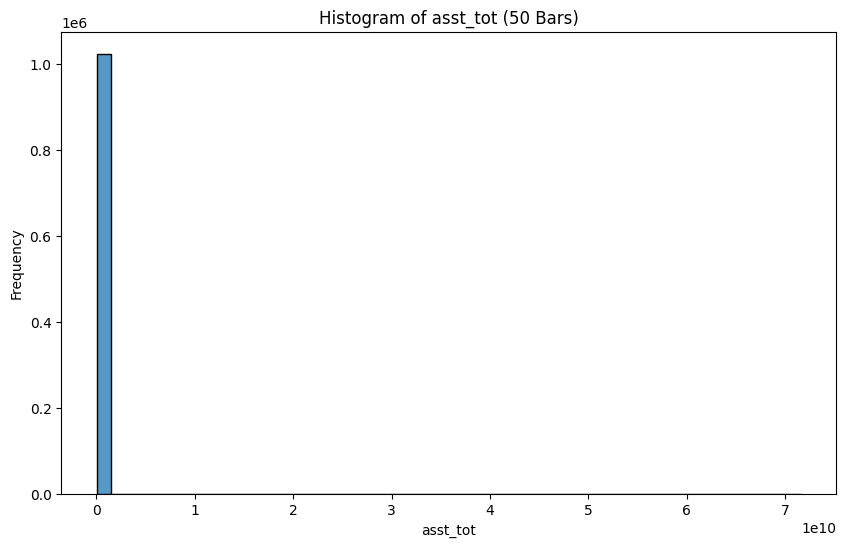

Feature: asst_tot_quantile - Number of null values: 0
Cutoff values for asst_tot_quantile:
[1.50000000e+06 1.72431020e+06 2.00320820e+06 2.35923020e+06
 2.82511560e+06 3.45842850e+06 4.37604760e+06 5.85366320e+06
 8.60520320e+06 1.58549462e+07 7.16446320e+10]


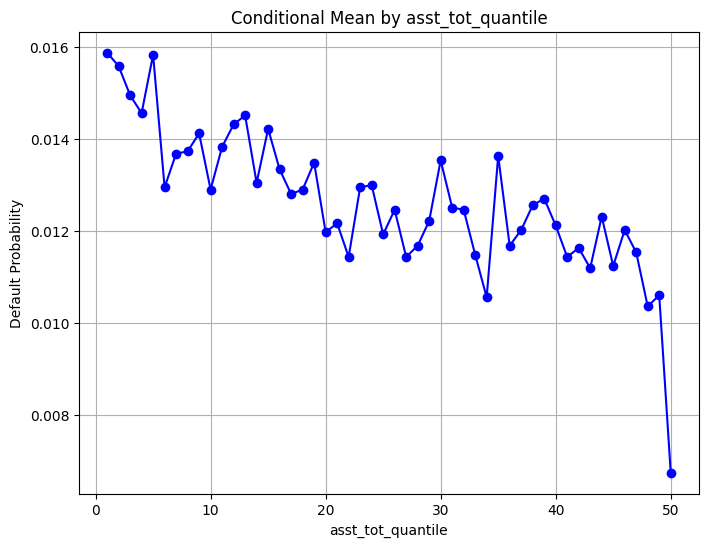

Feature: financial_leverage - Number of null values: 0


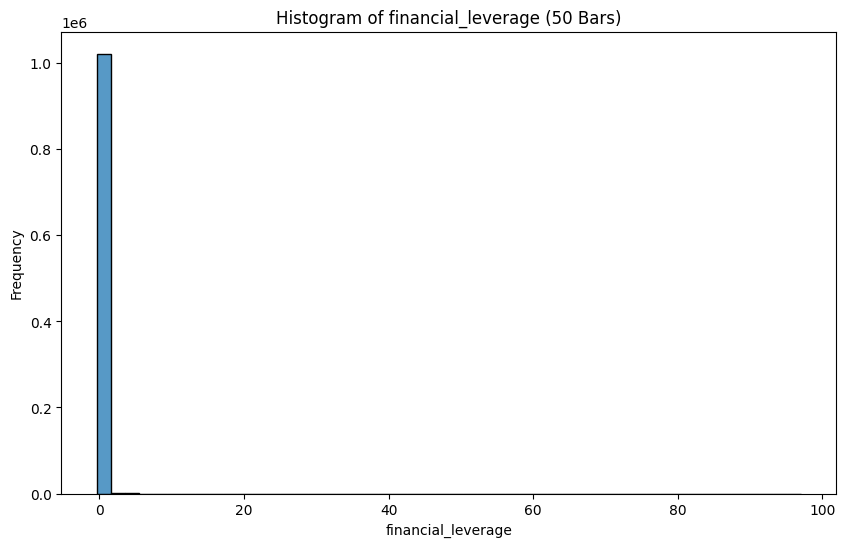

Feature: financial_leverage_quantile - Number of null values: 1
Cutoff values for financial_leverage_quantile:
[-0.41400349  0.23504806  0.4168535   0.55232065  0.65925375  0.74607064
  0.8193489   0.88152054  0.93480406  0.97848295 97.07777557]


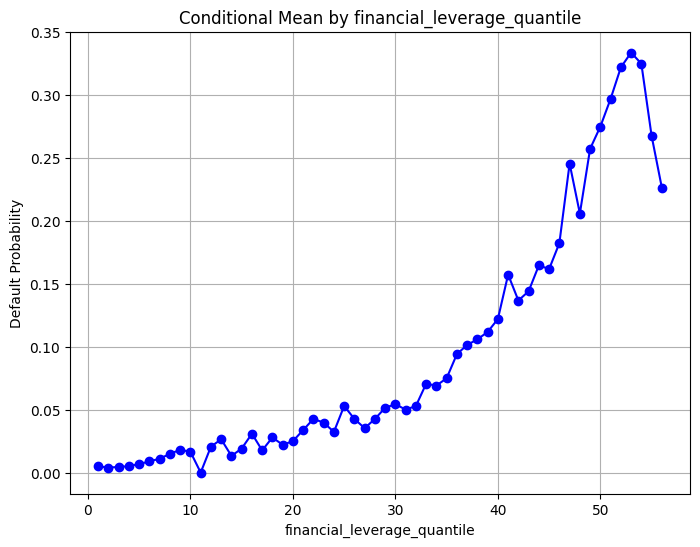

Feature: profitability_ratio - Number of null values: 0


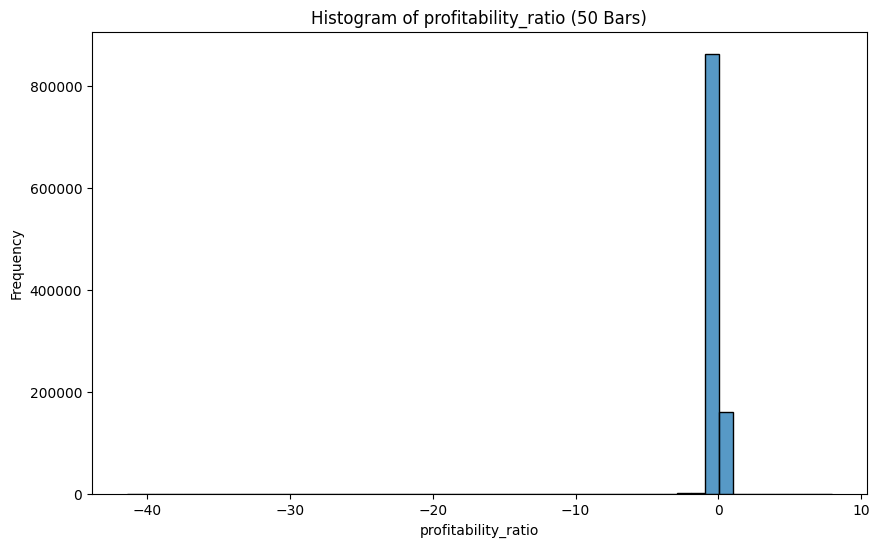

Feature: profitability_ratio_quantile - Number of null values: 1
Cutoff values for profitability_ratio_quantile:
[-4.14200057e+01 -3.32851827e-02 -1.07635419e-02 -2.71434540e-03
  6.76845050e-04  2.96631197e-03  7.13239462e-03  1.45633645e-02
  2.86289303e-02  6.15834333e-02  7.93641684e+00]


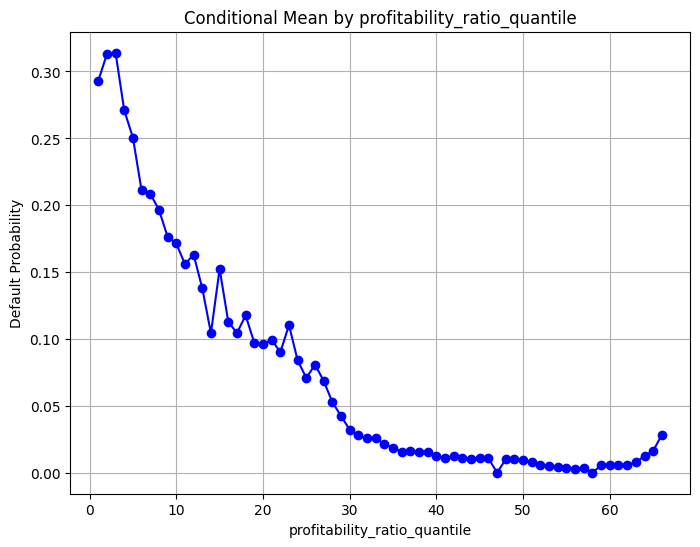

Feature: net_income_growth - Number of null values: 0


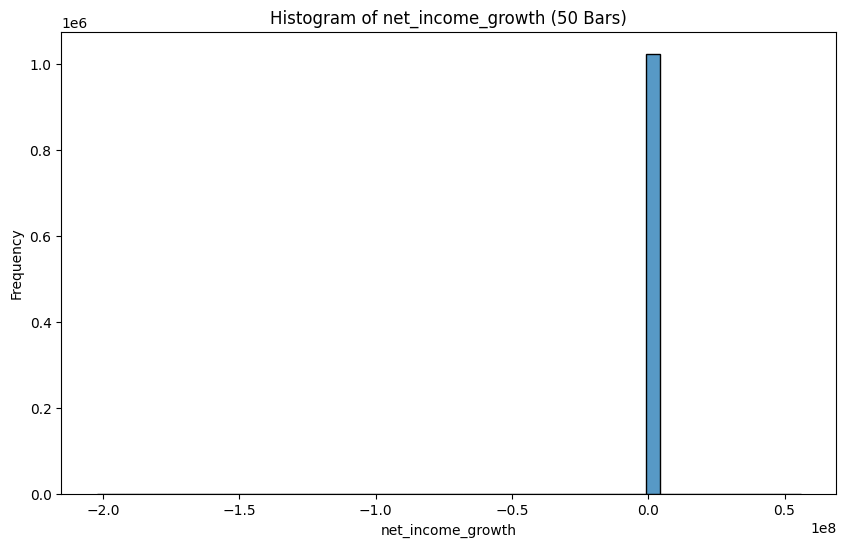

Feature: net_income_growth_quantile - Number of null values: 1
Cutoff values for net_income_growth_quantile:
[-2.02445801e+08 -1.90537872e+00 -9.38697884e-01 -5.60310460e-01
 -2.06205560e-01  0.00000000e+00  8.51336528e-03  4.43956437e-01
  1.86661882e+00  5.60637990e+07]


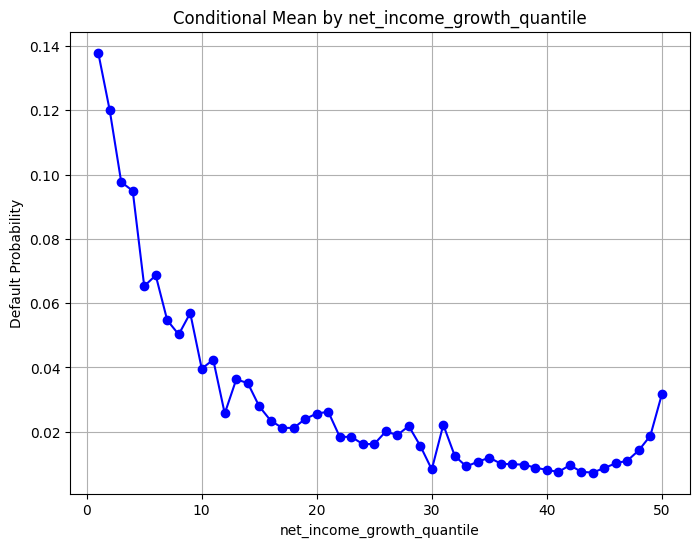

Feature: quick_ratio_v2 - Number of null values: 0


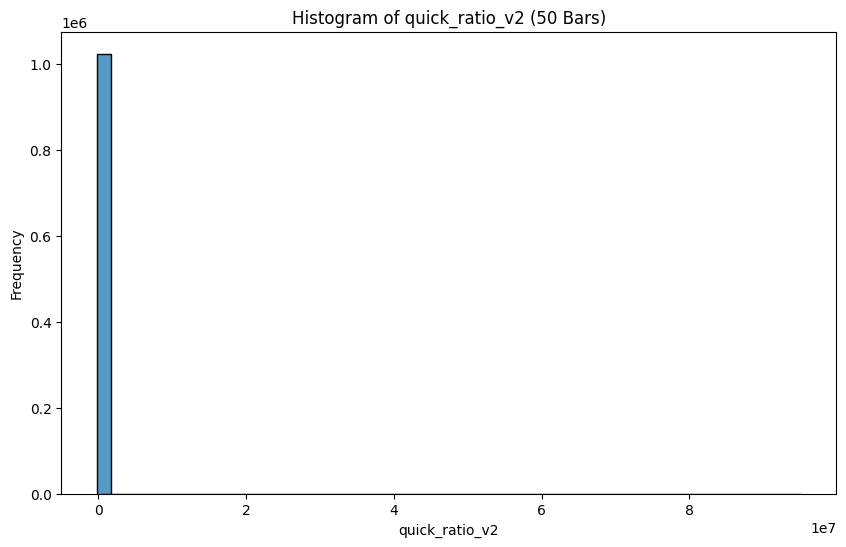

Feature: quick_ratio_v2_quantile - Number of null values: 0
Cutoff values for quick_ratio_v2_quantile:
[-2.34932000e+05  1.18312266e-01  2.75982746e-01  4.62058317e-01
  6.34033878e-01  7.92384570e-01  9.56024467e-01  1.15055851e+00
  1.54574969e+00  2.80422792e+00  9.51000000e+07]


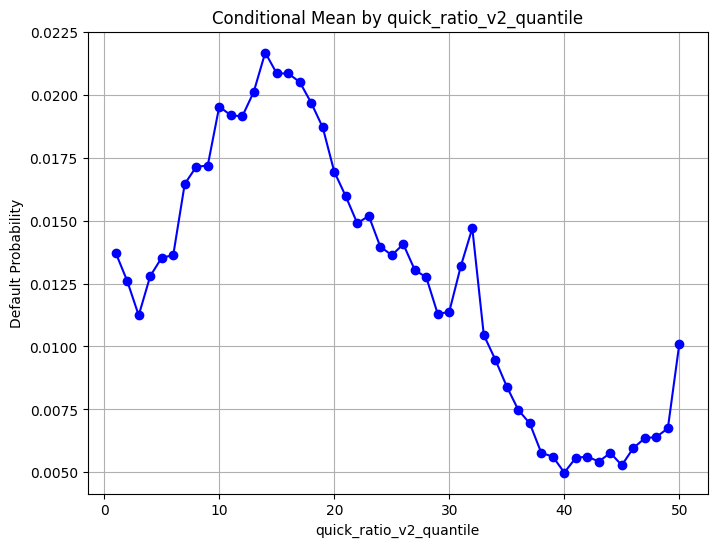

Feature: sales_growth - Number of null values: 0


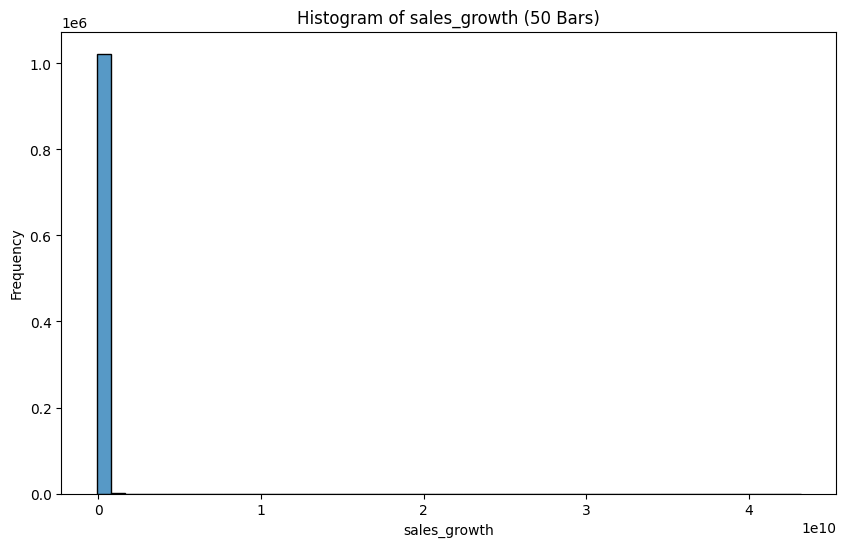

Feature: sales_growth_quantile - Number of null values: 0
Cutoff values for sales_growth_quantile:
[-1.11729936e+08  8.43491000e+04  2.72259600e+05  6.58822100e+05
  1.27196640e+06  1.98308000e+06  2.83358640e+06  4.04966310e+06
  6.25112020e+06  1.21994419e+07  4.32068810e+10]


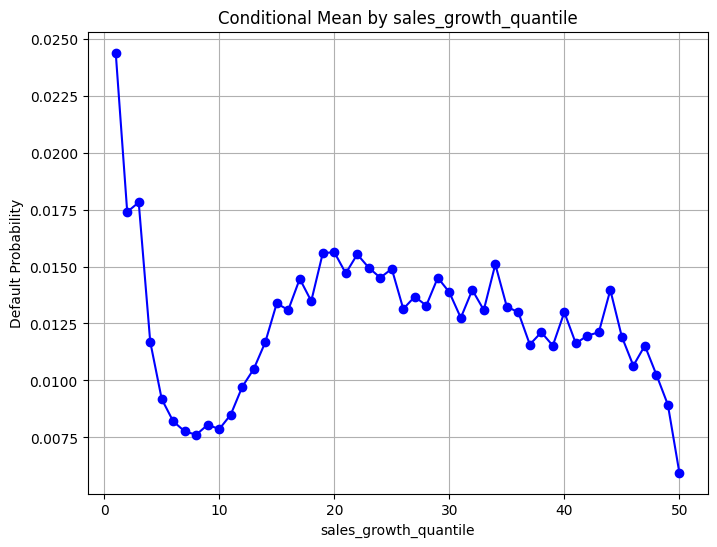

Feature: cash_assets_ratio - Number of null values: 0


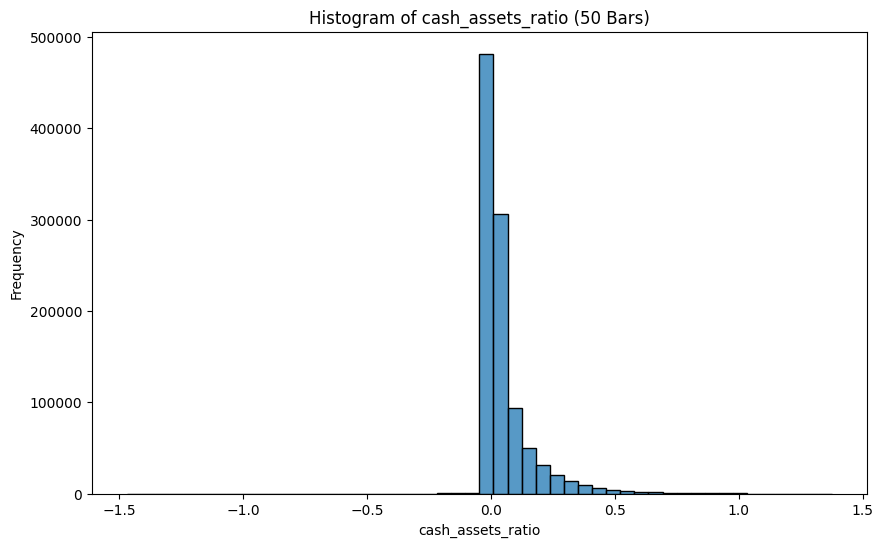

Feature: cash_assets_ratio_quantile - Number of null values: 0
Cutoff values for cash_assets_ratio_quantile:
[-1.46853336e+00  2.03083208e-04  9.14614929e-04  2.53822387e-03
  5.80625237e-03  1.19345786e-02  2.29534983e-02  4.28131675e-02
  8.06214412e-02  1.65775810e-01  1.37441997e+00]


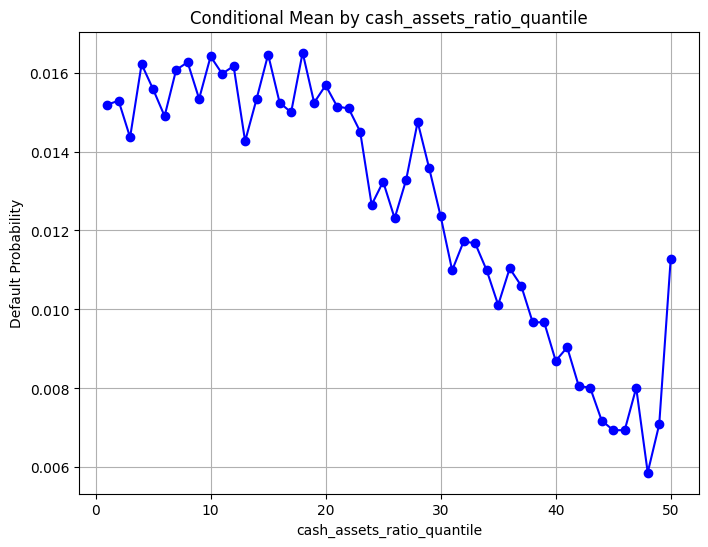

Feature: roa - Number of null values: 0


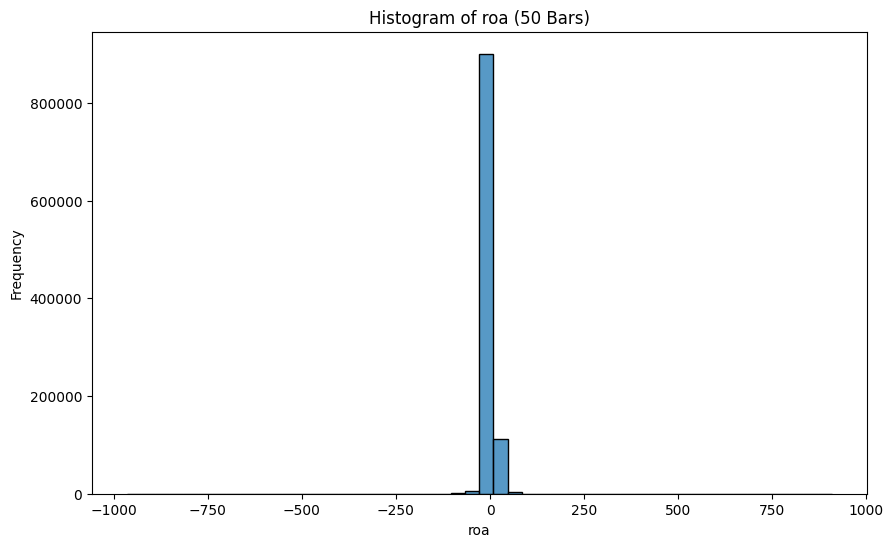

Feature: roa_quantile - Number of null values: 0
Cutoff values for roa_quantile:
[-9.6390e+02 -2.2500e+00 -2.7000e-01  6.0000e-01  1.5200e+00  2.3900e+00
  3.3200e+00  4.4500e+00  6.1700e+00  1.0020e+01  9.0756e+02]


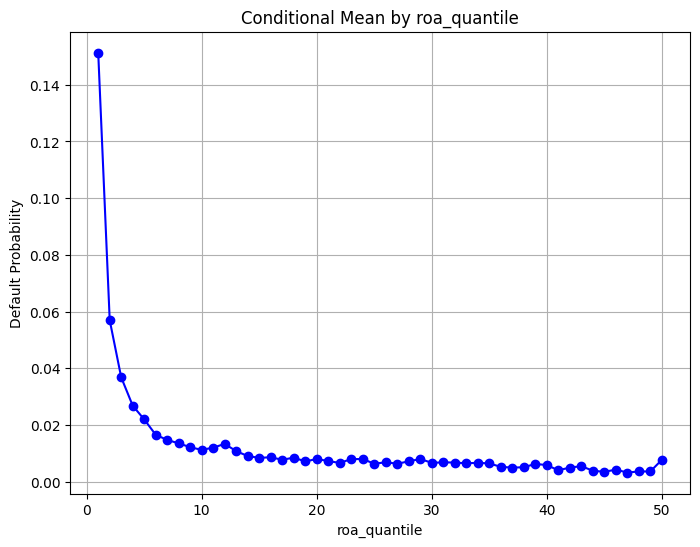

Feature: dscr - Number of null values: 0


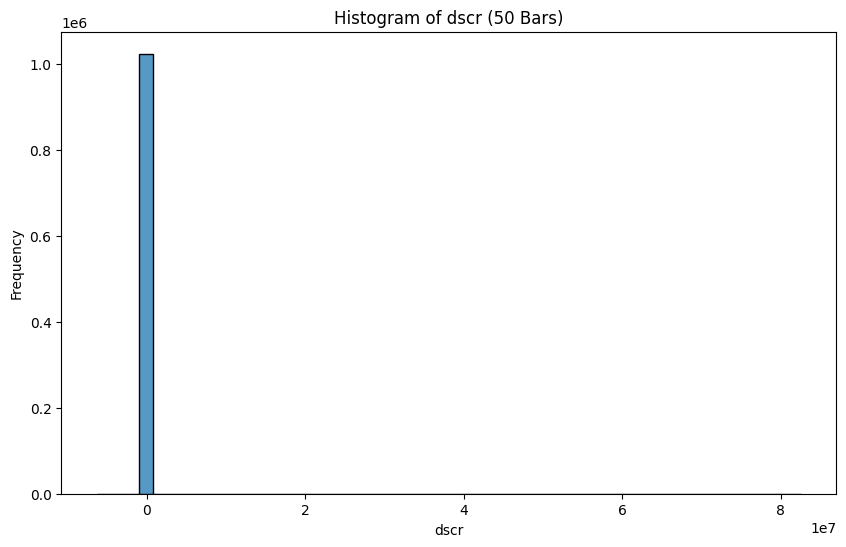

Feature: dscr_quantile - Number of null values: 0
Cutoff values for dscr_quantile:
[-6.31911200e+06 -1.75459477e+00  5.48949545e-01  1.35946658e+00
  2.15334642e+00  3.14850074e+00  4.81052590e+00  8.30104412e+00
  1.85002391e+01  7.77382580e+01  8.25376410e+07]


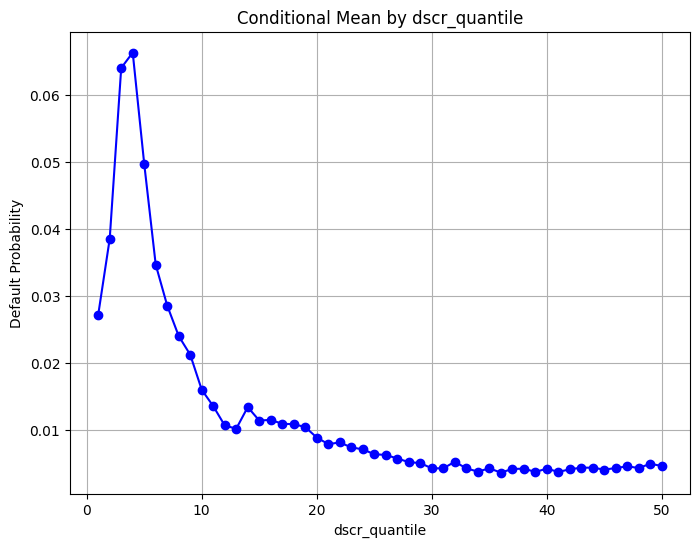

Feature: ebitda - Number of null values: 0


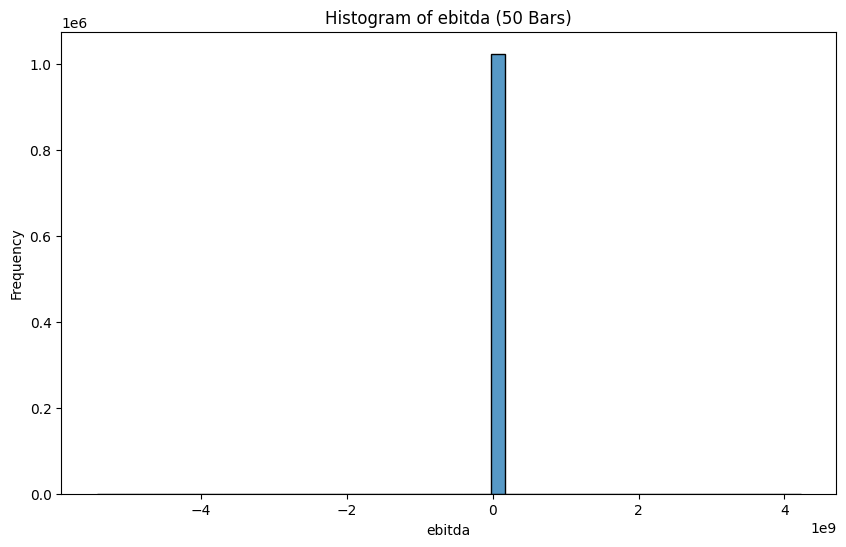

Feature: is_first_occurrence - Number of null values: 0


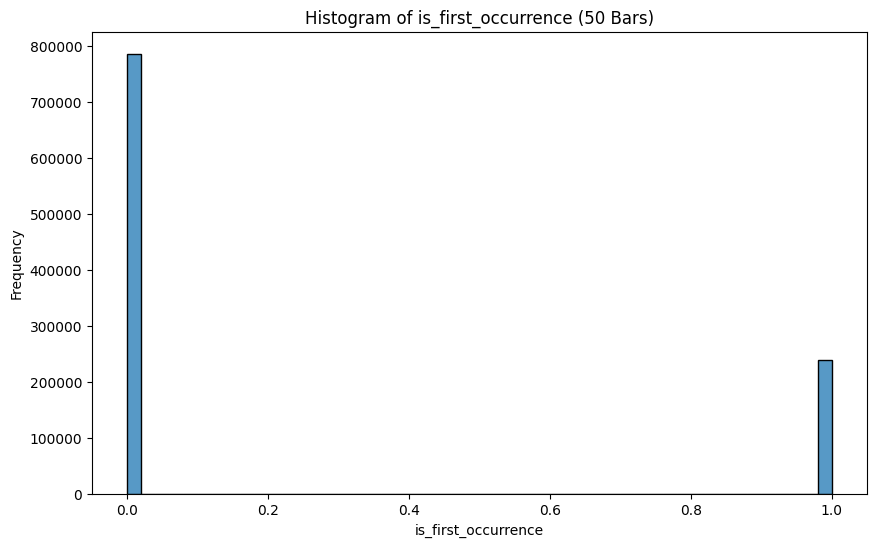

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Loop over all features, checking their presence in the DataFrame
for feature in features:
    if feature in df.columns:
        # 1. Print the number of null values for each feature
        null_count = df[feature].isnull().sum()
        print(f"Feature: {feature} - Number of null values: {null_count}")

        # 2. Plot histogram for non-quantile features
        if 'quantile' not in feature:
            try:
                plt.figure(figsize=(10, 6))
                sns.histplot(df[feature], bins=50)
                plt.title(f'Histogram of {feature} (50 Bars)')
                plt.xlabel(feature)
                plt.ylabel('Frequency')
                plt.show()
            except Exception as e:
                print(f"Chart wouldn't work for histogram of {feature}: {e}")

        # 3. For quantile features, print cutoff values and plot conditional default graph
        if 'quantile' in feature:
            try:
                # Print quantile cutoff values
                original_feature = feature.replace('_quantile', '')
                if original_feature in df.columns:
                    quantiles_cutoffs = pd.qcut(df[original_feature], q=10, retbins=True, duplicates="drop")[1]
                    print(f"Cutoff values for {feature}:")
                    print(quantiles_cutoffs)

                # Calculate conditional mean using 'default' if available, else using the first non-quantile feature
                if 'default' in df.columns:
                    quantile_rate = df.groupby(feature)['default'].mean()
                else:
                    quantile_rate = df.groupby(feature)[features[0]].mean()  # Use first non-quantile feature as fallback

                # Plot conditional mean or default probability
                plt.figure(figsize=(8, 6))
                plt.plot(quantile_rate.index, quantile_rate.values, marker='o', linestyle='-', color='b')
                plt.title(f'Conditional Mean by {feature}')
                plt.xlabel(feature)
                plt.ylabel('Default Probability' if 'default' in df.columns else f'Mean {features[0]}')
                plt.grid(True)
                plt.show()
            except Exception as e:
                print(f"Chart wouldn't work for quantile plot of {feature}: {e}")
    else:
        print(f"Feature: {feature} - Not found in DataFrame")


In [13]:
df.to_csv('../data/processed_data.csv',index=False)